<a href="https://colab.research.google.com/github/parniame/Time-series-forcasting/blob/main/forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")


# Read Data

In [ ]:
#read data
data = pd.read_csv('XAUUSD.csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,7/4/2023 0:00,1921.07,1930.22,1920.34,1929.65,858,0.44
1,7/3/2023 0:00,1917.70,1930.50,1910.11,1921.17,347,0.18
2,7/2/2023 0:00,1920.30,1920.30,1917.50,1917.70,-260,-0.14
3,6/30/2023 0:00,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,6/29/2023 0:00,1909.47,1913.00,1893.16,1908.76,-71,-0.04


# Data prossesing

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']
data.drop(columns= ['Date'],inplace = True)
data.head(10)

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2023-07-04,1921.07,1930.22,1920.34,1929.65,858,0.44
2023-07-03,1917.70,1930.50,1910.11,1921.17,347,0.18
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-28,1915.26,1916.98,1903.46,1909.58,-568,-0.30
2023-06-27,1922.57,1930.04,1910.60,1915.39,-718,-0.37
2023-06-26,1925.22,1933.18,1920.40,1922.28,-294,-0.15
2023-06-25,1927.30,1927.30,1920.51,1925.29,-201,-0.10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 622 entries, 2023-07-04 to 2021-07-04
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          622 non-null    float64
 1   High          622 non-null    float64
 2   Low           622 non-null    float64
 3   Close         622 non-null    float64
 4   Change(Pips)  622 non-null    int64  
 5   Change(%)     622 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 34.0 KB


# Convert to regular time series

Note :dataset is not containing regular/daily data, We can use just monthly avg data. That will give us  regular data.

In [ ]:
data = data.resample('m').mean()
data.shape

(25, 6)

In [ ]:
data.isna().sum()

Open            0
High            0
Low             0
Close           0
Change(Pips)    0
Change(%)       0
dtype: int64

In [ ]:
data.head()

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-31,1806.070000,1814.512500,1798.400417,1807.131250,106.125000,0.057083
2021-08-31,1785.374074,1794.892593,1773.330370,1785.393704,1.962963,-0.004074
2021-09-30,1780.585000,1789.510000,1769.835000,1778.029615,-255.538462,-0.146154
2021-10-31,1774.471923,1784.048462,1766.313462,1775.497692,102.576923,0.056154
2021-11-30,1819.928800,1830.565200,1808.555200,1819.414400,-51.440000,-0.031200


# Stationarity

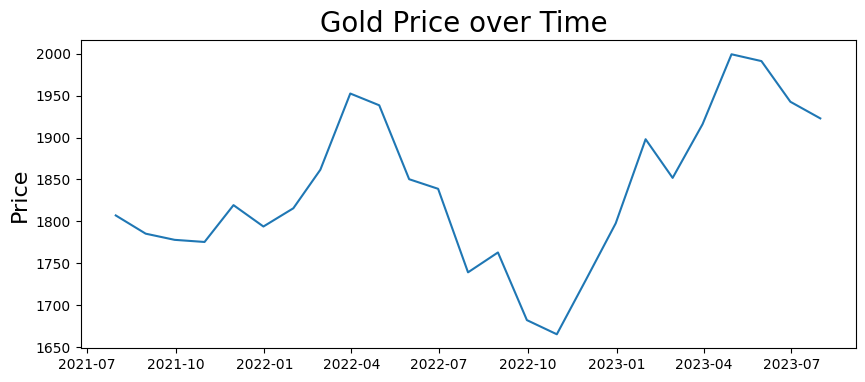

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(data.Close)
plt.title('Gold Price over Time ', fontsize=20)
plt.ylabel('Price', fontsize=16);


In [ ]:
# Check stationarity
result = adfuller(data.Close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values: ')
for key, value in result[4].items():
  print('\t{0}: {1}'.format(key, round(value, 3)))


ADF Statistic: -3.7920129251996237
p-value: 0.002990098521212137
Critical Values: 
	1%: -3.833
	5%: -3.031
	10%: -2.656


Note : it can be observed that the ADF statistic is negetiver than the 5% critical values.so data is stationary.



*   P-value ≤ Significance level = 0.05
*   Test statistic ≤ critical value






Note : d = 0

# Get MA & AR Parameters based on ACF and PACF plots

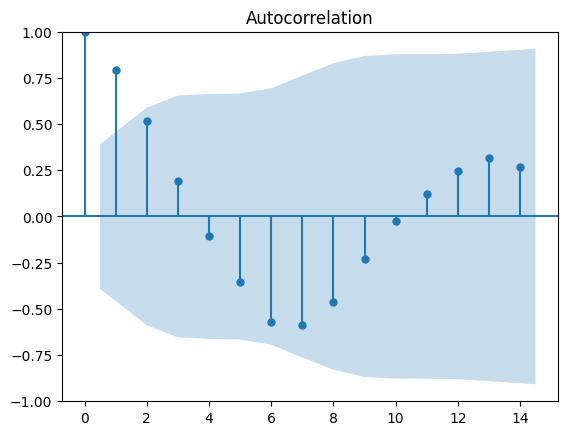

In [ ]:
fix , ax = plt.subplots()
acf_plot = plot_acf(data['Close'],ax = ax,lags = 14);

Note : Based on ACF, we should start with a  MA(1) process
q = 1

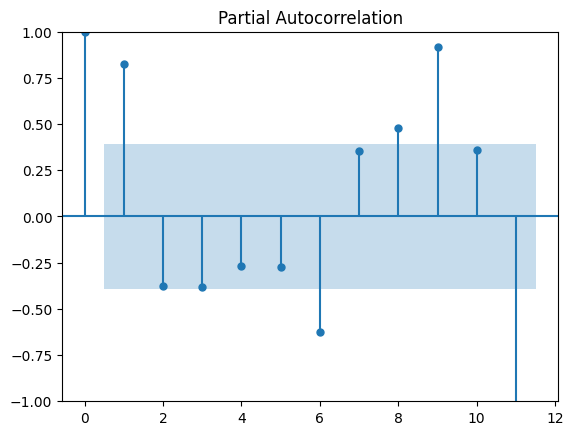

In [304]:
pacf_plot = plot_pacf(data['Close'],lags = 11);

Note : Based on PACF, we should start with a AR(1) process
p = 1

# Split train & test set

In [ ]:
#Size of data
data.index = pd.DatetimeIndex(data.index)
data_ = data['Close']

Number_Elements = len(data_)

#Use 70% of data as training, rest 30% to Test model
train_size = int(Number_Elements * 0.7)
train_data = data_[0:train_size]
test_data = data_[train_size:Number_Elements]
train_data.shape

(17,)

# Fit ARIMA Model

In [ ]:
models = []
for i in [1,6,9,11]:
  #create the model
  model = ARIMA(train_data, order=(i,0,1))
  #fit the model
  model_fit = model.fit()
  models.append(model_fit)
  print('AIC at lag %d :'%(i),model_fit.aic)
  print('----')
model_fit = models[1]

AIC at lag 1 : 266.8499840192459
----
AIC at lag 6 : 256.63958165874556
----
AIC at lag 9 : 262.77527590004314
----
AIC at lag 11 : 263.7792988118717
----


Note : the lowest AIC is at lag 6, p =6

# Prediction

In [ ]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

# Evaluate

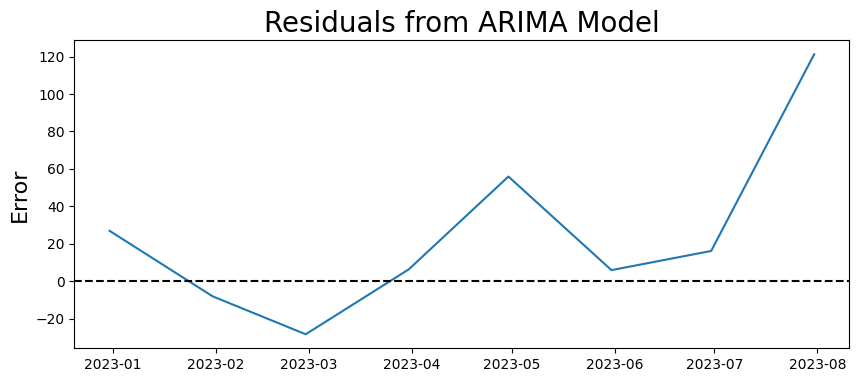

In [ ]:
residuals = test_data - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16);


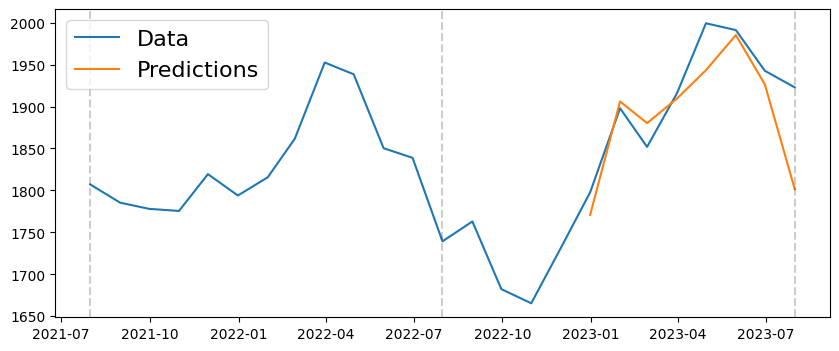

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(data_)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
start_year = data_.index[0].year
end_year = data_.index[-1].year
for year in range(start_year,end_year+1):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'), color='k', linestyle='--', alpha=0.2);

In [ ]:
print('Mean Absolute Percent Error:', (np.mean(abs(residuals/test_data)*100)))

Mean Absolute Percent Error: 1.7522427834906618


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 49.698413581910266
